# FlexNet

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.convnet import *
from cs231n.solver import Solver
from cs231n.data_utils import get_CIFAR10_data

/Users/carl/anaconda/envs/pitou/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Sanity check: Overfit small data

In [13]:
data = get_CIFAR10_data()
num_train = 20
small_data = {
'X_train': data['X_train'][:num_train],
'y_train': data['y_train'][:num_train],
'X_val': data['X_val'],
'y_val': data['y_val'],
}

for n, d in small_data.items():
    print n, d.shape

input_dim = small_data['X_train'].shape[1:]

y_val (1000,)
X_val (1000, 3, 32, 32)
X_train (20, 3, 32, 32)
y_train (20,)


In [8]:
results = {}

In [9]:
# Hyper parameter search

def uniform(minv, maxv):
    return np.random.rand() * (maxv - minv) + minv

best_solver = None
best_model = None
best_train_acc = -1

for _ in range(20):
    weight_scale = 1e-3  # 10 ** uniform(-4, -2)
    learning_rate = 10 ** uniform(-3, -1)
    reg = 10 ** uniform(-3, 2)
    
    model = model = FlexNet(input_dim=input_dim, num_filters=(8, 8, 16, 16), hidden_dim=(100,),
                            reg=reg)
    solver = Solver(model, small_data,
                    print_every=10, num_epochs=5, batch_size=50,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': learning_rate,
                    },
                    verbose=False)
    solver.train()
    train_acc = solver.train_acc_history[-1]
    final_loss = solver.loss_history[-1]
    format_str = '{:e} {:e}  final l: {:.5f}  train acc: {}'
    print format_str.format(reg, learning_rate, final_loss, train_acc)
    if final_loss > 10:
        continue
    plt.plot(solver.loss_history)
    results[(reg, learning_rate)] = train_acc
    if train_acc > best_train_acc:
        best_train_acc = train_acc
        best_solver = solver
        best_model = model

plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

6.289102e+00 1.678234e-02  final l: 2.45579  train acc: 0.25
2.115974e-02 3.435250e-02  final l: 2.17247  train acc: 0.25
5.863540e+01 1.039415e-03  final l: 2.60687  train acc: 0.35
5.861314e+00 1.066969e-02  final l: 2.33354  train acc: 0.25
6.138225e-01 1.483132e-02  final l: 2.28982  train acc: 0.25
3.418913e-02 2.567438e-03  final l: 2.28377  train acc: 0.15
2.196436e-02 8.202148e-02  final l: 2.27598  train acc: 0.25
3.229976e+01 1.118910e-03  final l: 2.50555  train acc: 0.15


KeyboardInterrupt: 

In [10]:
model.print_params()


--- Network parameters ---
Name       Shape
----       -----
Waf0       (64, 100)
Wcoa0      (8, 3, 3, 3)
Wcoa1      (8, 8, 3, 3)
Wcoa2      (16, 8, 3, 3)
Wcoa3      (16, 16, 3, 3)
Wcob0      (8, 8, 3, 3)
Wcob1      (8, 8, 3, 3)
Wcob2      (16, 16, 3, 3)
Wcob3      (16, 16, 3, 3)
Wlast      (100, 10)
baf0       (100,)
bcoa0      (8,)
bcoa1      (8,)
bcoa2      (16,)
bcoa3      (16,)
bcob0      (8,)
bcob1      (8,)
bcob2      (16,)
bcob3      (16,)
beta_af0   (100,)
beta_coa0  (8,)
beta_coa1  (8,)
beta_coa2  (16,)
beta_coa3  (16,)
beta_cob0  (8,)
beta_cob1  (8,)
beta_cob2  (16,)
beta_cob3  (16,)
blast      (10,)
gamma_af0  (100,)
gamma_coa0 (8,)
gamma_coa1 (8,)
gamma_coa2 (16,)
gamma_coa3 (16,)
gamma_cob0 (8,)
gamma_cob1 (8,)
gamma_cob2 (16,)
gamma_cob3 (16,)
Total params: 18006


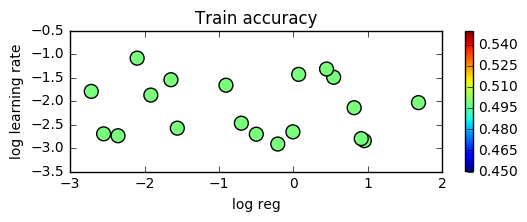

In [5]:
# Visualize the cross-validation results
import math
marker_size = 100
x_scatter, x_label = [np.log10(x[0]) for x in results], 'log reg'
y_scatter, y_label = [np.log10(x[1]) for x in results], 'log learning rate'

# plot validation accuracy
colors = [results[x] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Train accuracy')
plt.show()

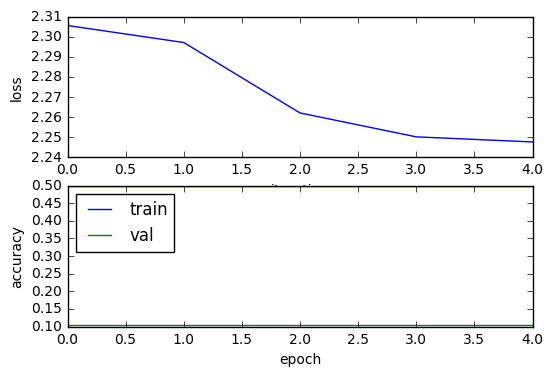

In [6]:
plt.subplot(2, 1, 1)
plt.plot(best_solver.loss_history, '-')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(best_solver.train_acc_history, '-')
plt.plot(best_solver.val_acc_history, '-')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()